Donau-Ries (Lkr): Äpfel und Birnen

Der Datensatz enthält Informationen zu besonderen Apfel- und Birnensorten in Nordschwaben, die im Rahmen eines LEADER-Projekts von 2016 bis 2020 erfasst wurden.
Dokumentiert wurden Sortenvielfalt, Verbreitung, Häufigkeit und Gefährdungsstatus von rund 400???(173) historischen Obstsorten in den Landkreisen
Donau-Ries, Neu-Ulm, Augsburg und Aichach-Friedberg. Ziel ist der Erhalt genetischer Vielfalt und regionaler Kultursorten durch fundierte Bestandsaufnahme und Dokumentation.

Aufgabe ist es, anhand der Daten herauszufinden, welche Sorten besonders stark für Feuerbrand anfällig

quelle : https://www.govdata.de/suche/daten/donau-ries-lkr-apfel-und-birnen

In [75]:
import requests

url = "https://fms.donau-ries.de/formcycle/datenabfragedb?mandantName=LRA-Donau-Ries&name=aepfel-und-birnen"

# Anfrage schicken
response = requests.get(url)

# prüfen ob alles ok war
if response.status_code == 200:
    data = response.json()   # JSON direkt als Python-Dict/Liste
    #print(data['result'])
else:
    print("Fehler beim Abrufen:", response.status_code)



In [76]:
from bs4 import BeautifulSoup
ls_keys = ["geschichte", "frucht", "reifezeit", "standort", "anfälligkeit", "blüte", "sonstiges" ]
alle_sorten = {}
number  = 0
for eintrag in data["result"]:
    alias = eintrag["alias"]
    
    html_text = eintrag["text_inhalt"]
    #quellen = eintrag.get("quellen", "")

    soup = BeautifulSoup(html_text, "html.parser")

    sorten_dict = {}
    current_key = None
    #print(soup)
    for tag in soup.find_all("p"):
        text = tag.get_text(strip=True)
        #print(tag)
        # Neue Sektion wenn <strong> drin ist
        if tag.find("strong"):
            current_key = text.replace(":", "").lower()
            if current_key=="früchte":
                current_key="frucht"
            sorten_dict[current_key] = ""
        else:
            if current_key:
                if sorten_dict[current_key]:
                    sorten_dict[current_key] += " " + text
                else:
                    sorten_dict[current_key] = text
    sorten_dict["ind"] = number
    alle_sorten[alias] = sorten_dict
    number += 1
#print(alle_sorten["blauapfel"])
#alle_sorten["horneburger-pfannkuchenapfel"]

#alle_sorten["suesskirsche-skeena"]

In [77]:

LS_KEYS = ["geschichte", "frucht", "reifezeit", "standort", "anfälligkeit", "blüte", "sonstiges", "ind"]
alle_sorten_cleaned  = {}
sorten_cleaned  = {}
for key, value in alle_sorten.items():
    
    for ke, val in value.items():
        if ke in LS_KEYS:
            sorten_cleaned[ke]= val
            continue
        else:
            for wort in LS_KEYS:
                if ke.startswith(wort):
                    sorten_cleaned[wort] =  ke[len(wort)::] 
                else:
                    continue
    alle_sorten_cleaned[key] = sorten_cleaned
    sorten_cleaned  = {}



In [78]:
import pandas as pd
df = pd.DataFrame(alle_sorten_cleaned)
df  = df.T
lss = df[df["anfälligkeit"].notna()]["anfälligkeit"].tolist()
lsn = df[df["anfälligkeit"].notna()]["ind"].tolist()

anf = dict(zip(lsn,lss))
df = df.reset_index().rename(columns={"index": "name"})


In [79]:
import re
Feuerbrand_filtered = {}
for i, s in anf.items():
    if "feuer" in anf[i].lower():
        for st in re.split(r"[,.]", anf[i]):
           if "feuer" in st.lower():
                Feuerbrand_filtered[i] = st 

In [80]:
#Feuerbrand_filtered
# gibt es einen unterschied zwischen gefährdet und anfällig?
# Wie kann man das Feuerbrandgefahr einstufen?

In [81]:
import re

LEVELS = {"sehr stark": 4, "stark": 3, "mittel": 2, "gering": 1, "resistent": 0}

def classify_level(text: str):
    if not text:
        return None
    # normalisieren
    t = text.lower()
    t = re.sub(r"[-–—]", " ", t)     # Bindestriche als Leerzeichen
    t = re.sub(r"\s+", " ", t).strip()

    # 0) resistent / nicht anfällig
    if any(x in t for x in ["feuerbrandresistent", "widerstandsfähig gegen feuerbrand", "nicht anfällig"]):
        return LEVELS["resistent"]

    # 4) sehr stark
    if ("sehr stark" in t or "besonders" in t or "hoch " in t) and ("anfällig" in t or "gefährdet" in t):
        return LEVELS["sehr stark"]

    # 3) stark
    if "stark" in t and ("anfällig" in t or "gefährdet" in t):
        return LEVELS["stark"]

    # 2) mittel / mäßig / mittelstark / mittelanfällig / mittlere(r/s)
    if any(x in t for x in ["mittelstark", "mittelanfällig", "mäßig", "mittlere ", "mittlerer", "mittleren", "mittleres", "mittlere", "mittlere", "mittlere"]) \
       or "mittlere" in t:
        return LEVELS["mittel"]

    # 1) gering / wenig / kaum
    if any(x in t for x in ["gering", "wenig", "kaum"]):
        return LEVELS["gering"]

    # nichts eindeutiges
    return None

classified = {k: classify_level(v) for k, v in Feuerbrand_filtered.items()}
#df_classified = pd.DataFrame(classified)
df_classified = pd.DataFrame(list(classified.items()), columns=["ind", "class_feuerbrand"])
df_classified.head(10)

,ind,class_feuerbrand
0,0,NaN
1,1,3.0
2,2,3.0
3,3,2.0
4,4,3.0
5,8,3.0
6,9,1.0
7,13,1.0
8,19,3.0
9,22,3.0


In [82]:
df_small = df[["name","ind"]]
merged = pd.merge(df_small, df_classified, on="ind", how="inner")
merged.head(10)

,name,ind,class_feuerbrand
0,alkmene,0,NaN
1,ananasrenette,1,3.0
2,baumanns-renette,2,3.0
3,berner-rosenapfel,3,2.0
4,bittenfelder-saemling,4,3.0
5,brettacher-gewuerzapfel,8,3.0
6,croncels,9,1.0
7,duelmener-rosenapfel,13,1.0
8,gelber-bellefleur,19,3.0
9,gewuerzluiken,22,3.0


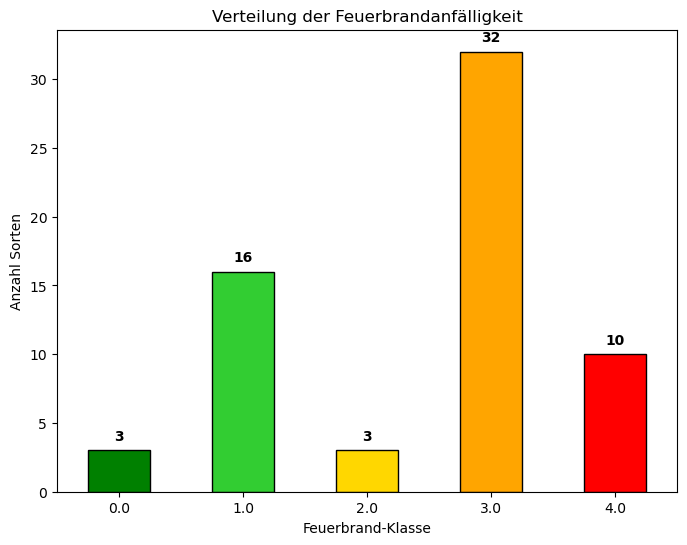

In [83]:
import matplotlib.pyplot as plt

# Häufigkeiten je Klasse zählen
counts = merged["class_feuerbrand"].value_counts().sort_index()

farben = ["green", "limegreen", "gold", "orange", "red"]

ax = counts.plot(
    kind="bar",
    color=farben[:len(counts)],
    edgecolor="black",
    figsize=(8,6)
)

plt.xlabel("Feuerbrand-Klasse")
plt.ylabel("Anzahl Sorten")
plt.title("Verteilung der Feuerbrandanfälligkeit")
plt.xticks(rotation=0)

# Werte über die Balken schreiben
for i, v in enumerate(counts):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.show()




In [84]:
merged[merged["class_feuerbrand"]==4]

,name,ind,class_feuerbrand
38,nordhaeuser-winterforelle,82,4.0
40,pastorenbirne,86,4.0
44,koestliche-von-charneux,92,4.0
47,fruehe-von-trevoux,99,4.0
55,bunte-julibirne,136,4.0
57,concorde,138,4.0
58,doppelte-philippsbirne,139,4.0
60,gelbmoestler,142,4.0
61,graefin-von-paris,143,4.0
71,packhams-triumph,155,4.0


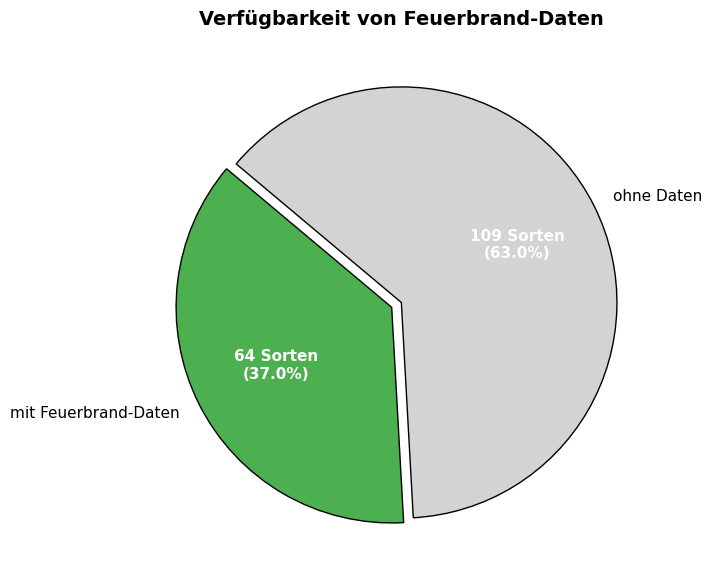

In [85]:
import matplotlib.pyplot as plt

gesamt = 173
mit_daten = 64
ohne_daten = gesamt - mit_daten

werte = [mit_daten, ohne_daten]
labels = ["mit Feuerbrand-Daten", "ohne Daten"]
farben = ["#4CAF50", "#D3D3D3"]
explode = (0.05, 0)

fig, ax = plt.subplots(figsize=(7,7))

def autopct_format(p):
    # finde den Wert passend zum Prozentanteil
    total = sum(werte)
    val = round(p*total/100)   # kein int(), sondern round()
    return f"{val} Sorten\n({p:.1f}%)"

wedges, texts, autotexts = ax.pie(
    werte,
    labels=labels,
    autopct=autopct_format,
    colors=farben,
    explode=explode,
    startangle=140,
    wedgeprops={"edgecolor": "black"},
    textprops={"fontsize": 11}
)

plt.setp(autotexts, fontweight="bold", color="white")
ax.set_title("Verfügbarkeit von Feuerbrand-Daten", fontsize=14, fontweight="bold")
plt.show()



In [87]:
from collections import Counter
import re
df_histo = pd.DataFrame.from_dict(anf, orient="index", columns=["text"])
# Alle Texte in eine Liste von Wörtern
words = []
for text in df_histo["text"]:
    # nur Buchstaben/Wörter behalten
    tokens = re.findall(r"[A-Za-zÄÖÜäöüß]+", text.lower())
    words.extend(tokens)

# Häufigkeiten zählen
counts = Counter(words)

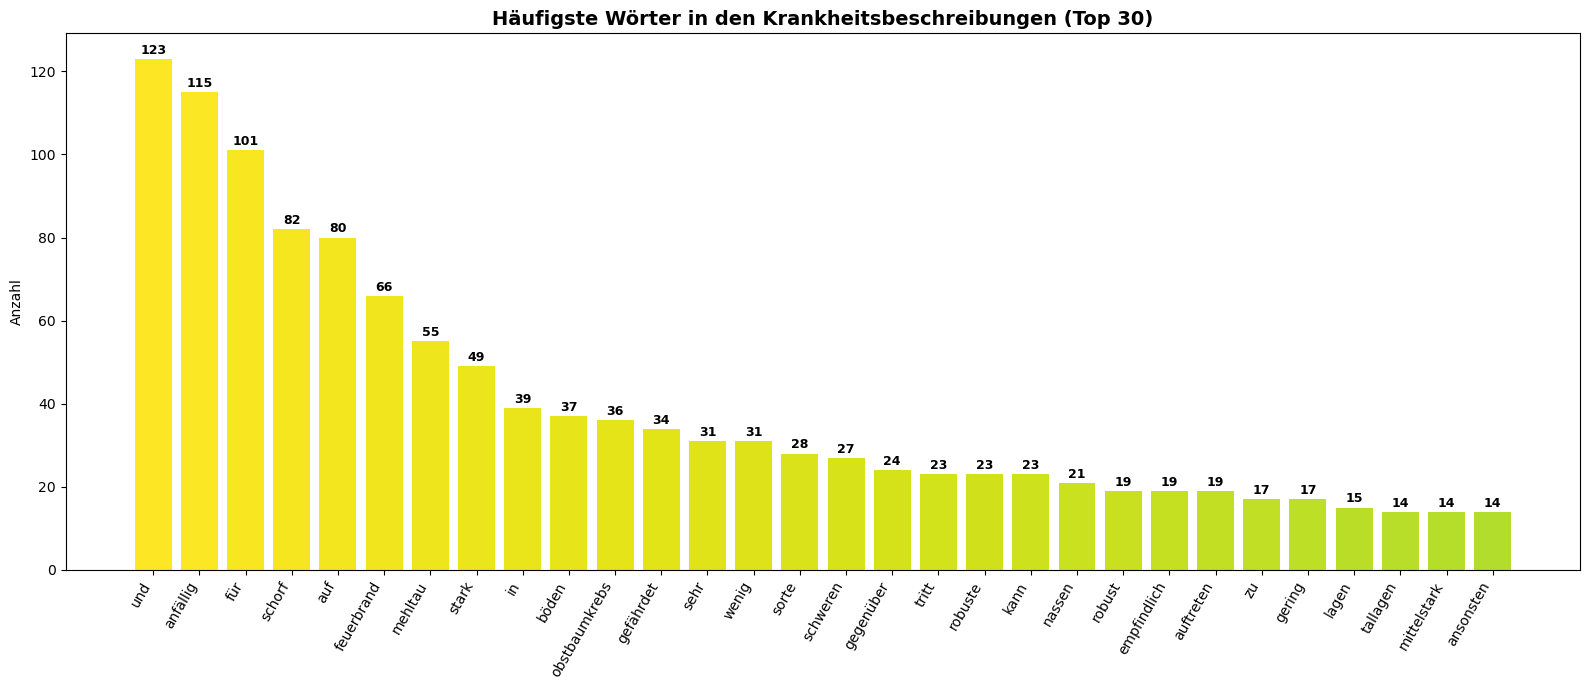

In [ ]:
import matplotlib.pyplot as plt

N = 30   # so viele Wörter anzeigen
common = counts.most_common(N)
labels, values = zip(*common)

# --- Fancy Plot ---
plt.figure(figsize=(16,7))  # breit machen

bars = plt.bar(labels, values, color=plt.cm.viridis_r(range(len(values))))

# Labels über den Balken
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(val), ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.xticks(rotation=60, ha="right")
plt.ylabel("Anzahl")
plt.title(f"Häufigste Wörter in den Krankheitsbeschreibungen (Top {N})", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


#Die Auswertung weist eine hohe Nennhäufigkeit von Schorf auf.
#Eine differenzierte Analyse der Kontextangaben ist für eine belastbare Aussage zur Anfälligkeit erforderlich.

In [95]:
import re # vll eine funktion erstellen ? 
schorf_filtered = {}
for i, s in anf.items():
    if "schorf" in anf[i].lower():
        for st in re.split(r"[,.]", anf[i]):
           if "schorf" in st.lower():
                schorf_filtered[i] = st 
schorf_filtered
# Für die erste Auswertung steht die Anfälligkeit im Vordergrund; Standort- oder Lagenfaktoren werden hierbei nicht berücksichtigt
# Die Texte sind etwas komplexer gestalltet, wie kann man hier weitergehen ohne extrem komplexe re zu verwenden?

{1: ' robust für Apfelschorf',
 2: ' Schorf',
 3: 'Anfällig für Schorf nur in Tallagen',
 4: ' Widerstandsfähig gegen Schorf und Obstbaumkrebs und gegenüber vielen tierischen Schädlingen',
 6: 'Kaum anfällig für Schorf',
 7: ' nassen Lagen anfällig für Schorf und Obstbaumkrebs',
 8: ' In geschlossenen Lagen Schorf möglich',
 9: ' In geschlossenen warmen Lagen stark für Schorf',
 11: 'In niedrigen Lagen anfällig für Schorf und Mehltau',
 13: ' Kaum Schorf anfällig',
 14: 'Wenig anfällig für Schorf',
 18: ' Auf schweren Böden kann Obstbaumkrebs und Schorf auftreten',
 19: ' In nassen Jahren Schorfanfällig',
 22: ' Es tritt kaum Schorf oder Mehltau auf',
 23: ' Schorf und Mehltau gefährdet',
 24: ' Wenig empfindlich gegenüber Schorf',
 25: 'Stark anfällig für Blattschorf',
 28: 'Wenig Schorfanfällig',
 30: ' Wenig anfällig für Schorf und Mehltau',
 31: ' In Tallagen Schorf und Blutlaus anfällig',
 32: ' In Tallagen anfällig für Schorf',
 34: ' Widerstandsfähig gegen Schorf und Mehltau',
 

In [97]:
import re # vll eine funktion erstellen ? 
schorf_filtered_2 = {}
for i, s in anf.items():
    if "schorf" in anf[i].lower():
        schorf_filtered_2[i] = s 
schorf_filtered_2

{1: 'Stark Feuerbrand gefährdet. Stark Mehltau anfällig, robust für Apfelschorf. Auf schweren oder nassen Böden tritt Obstbaumkrebs auf. Anfällig für Apfelwickler und Blutlaus.',
 2: 'Stark anfällig für Feuerbrand, Triebsucht, Schorf, Krebs. Auch anfällig für Stippe, Blatt- und Blutläuse.',
 3: 'Anfällig für Schorf nur in Tallagen. Mittelanfällig für Feuerbrand. Empfindlich gegenüber Schwefelmitteln.',
 4: 'Mittelstark anfällig für Feuerbrand. Widerstandsfähig gegen Schorf und Obstbaumkrebs und gegenüber vielen tierischen Schädlingen.',
 6: 'Kaum anfällig für Schorf. Sehr frosthart.',
 7: 'In geschlossenen, nassen Lagen anfällig für Schorf und Obstbaumkrebs. Mittelstark anfällig für Mehltau.',
 8: 'Stark Feuerbrand gefährdet. Auf schweren Böden tritt vermehrt Obstbaumkrebs auf. In geschlossenen Lagen Schorf möglich. Ansonsten sehr widerstandsfähig.',
 9: 'Geringe Feuerbrandanfälligkeit. In geschlossenen warmen Lagen stark für Schorf, Mehltau und Triebsucht. Auf schweren Böden tritt Obs